/var/folders/cf/gdxp_xmx5dq_st499q4049gr0000gn/T/ipykernel_24310/2175491966.py:108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  roll_dates = pd.date_range(start=global_start_date, end=global_end_date, freq=roll_freq)
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching data for CL=F...
Fetching data for USO...

Testing Base Case for Crude Oil...

Testing High Volatility for Crude Oil...

Testing Persistent Contango for Crude Oil...

Testing Market Shock for Crude Oil...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Fetching data for GC=F...
Fetching data for GLD...

Testing Base Case for Gold...

Testing High Volatility for Gold...

Testing Persistent Contango for Gold...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Testing Market Shock for Gold...
Fetching data for ZW=F...
Fetching data for WEAT...

Testing Base Case for Wheat...

Testing High Volatility for Wheat...

Testing Persistent Contango for Wheat...



Testing Market Shock for Wheat...


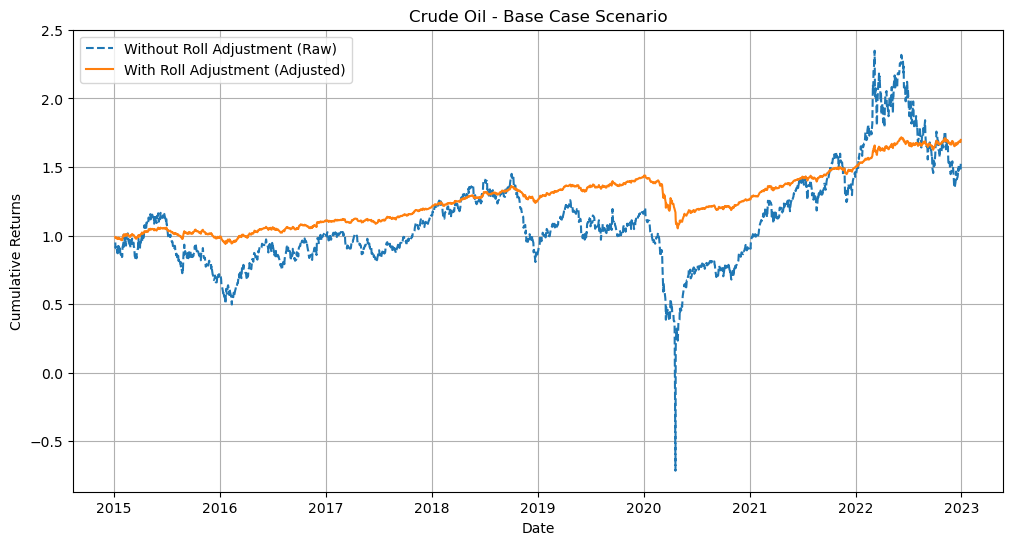

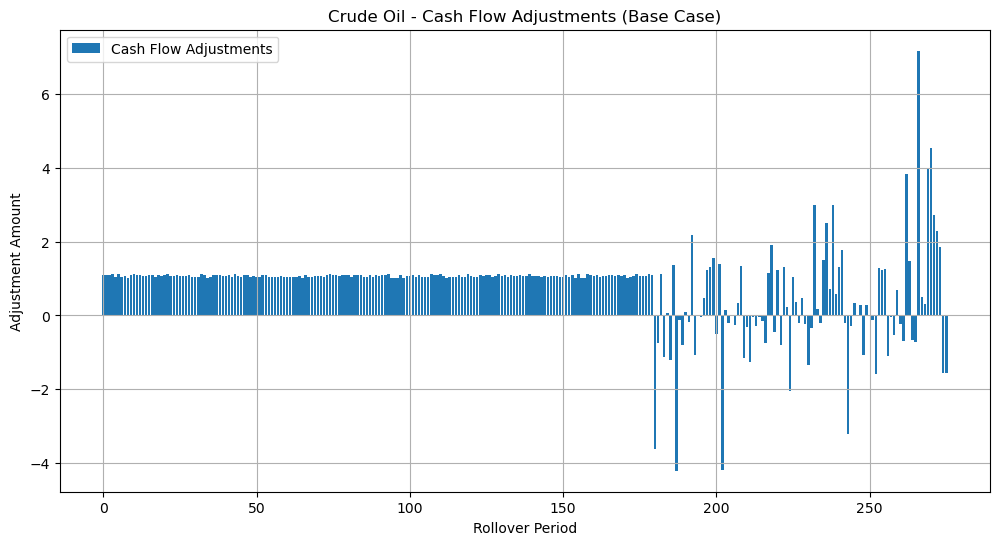

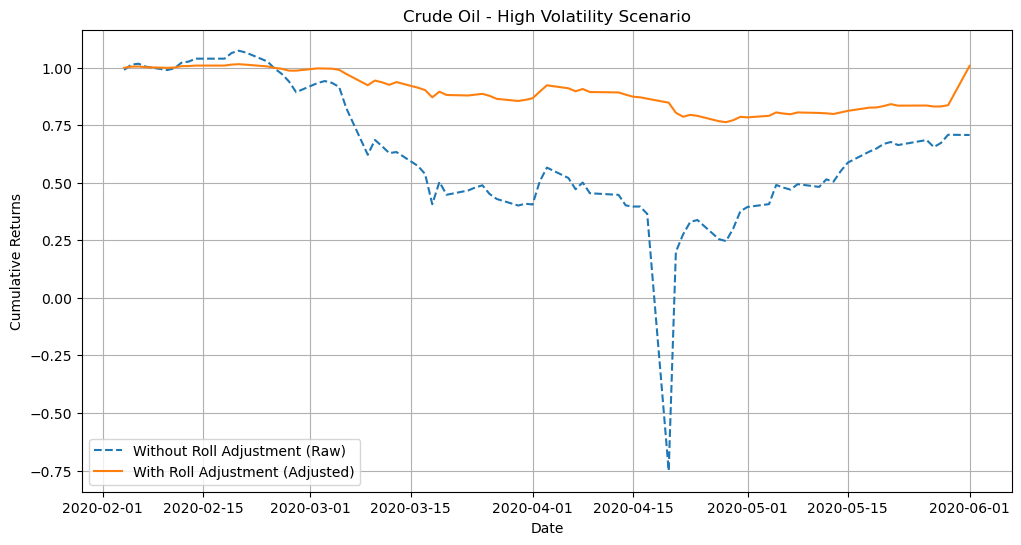

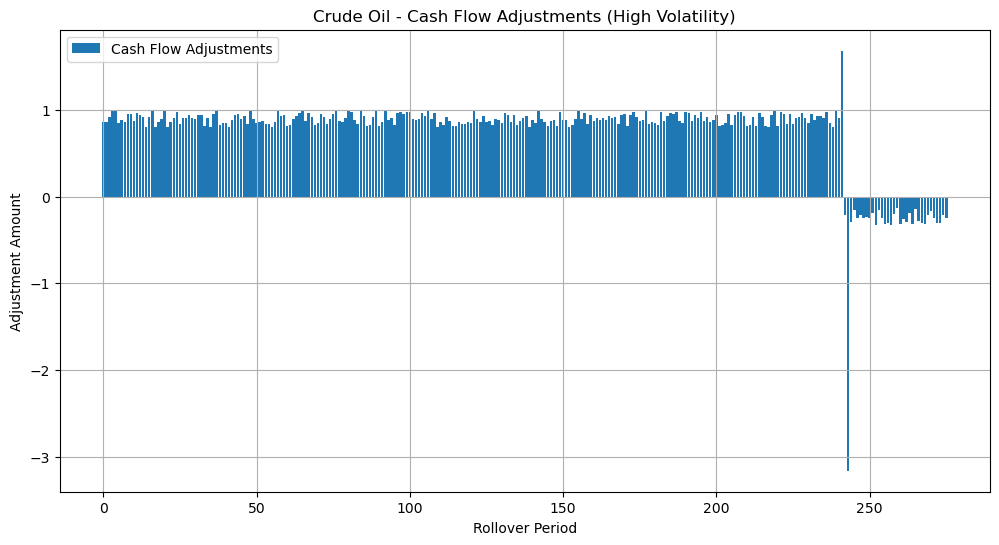

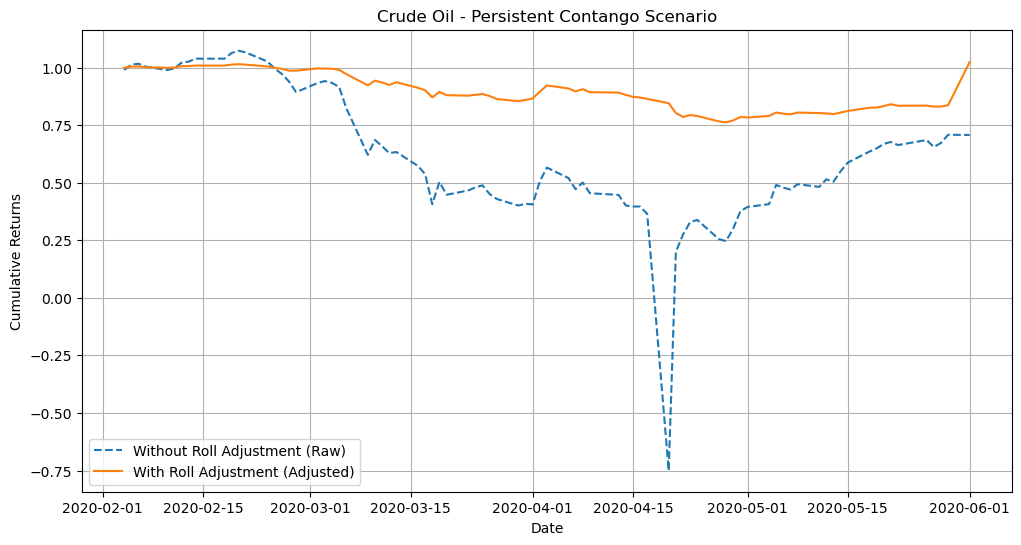

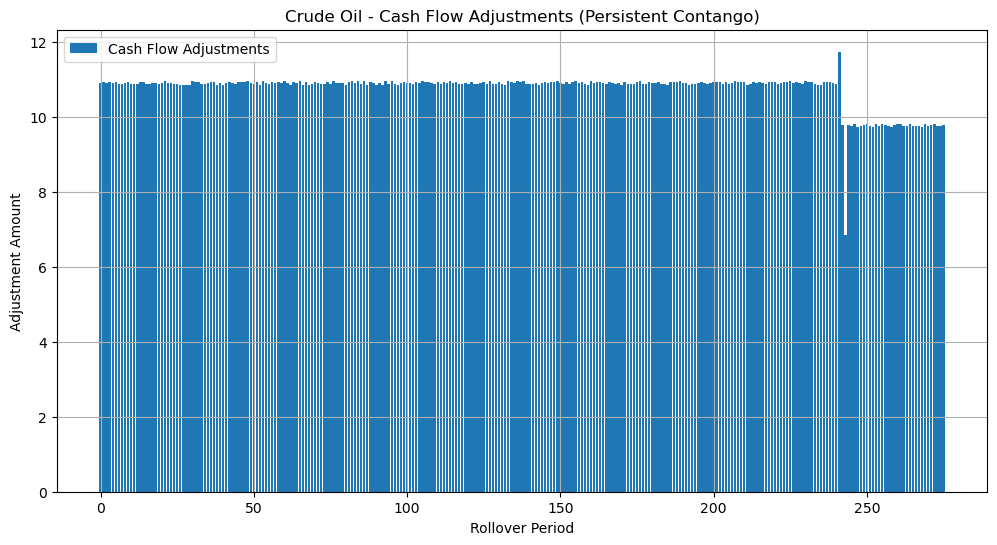

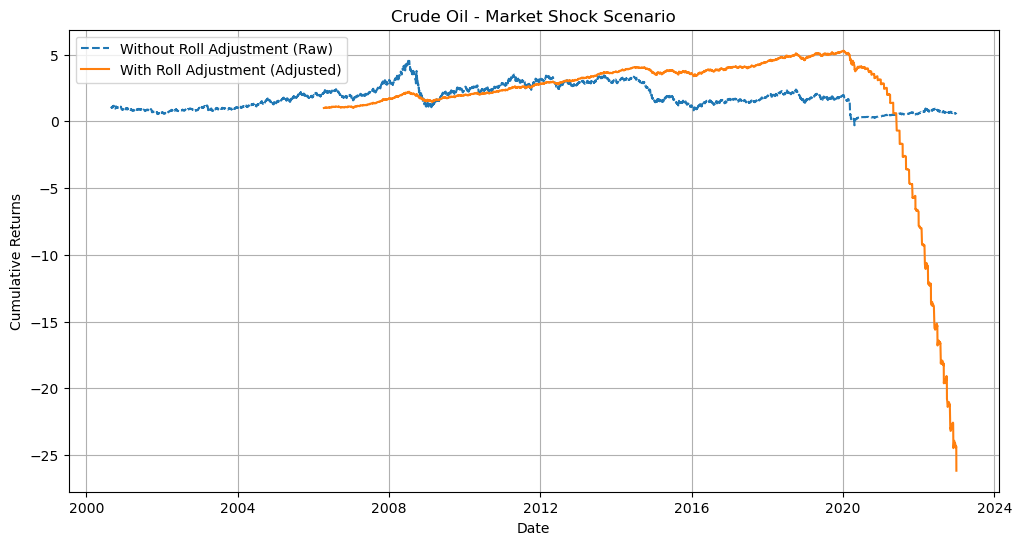

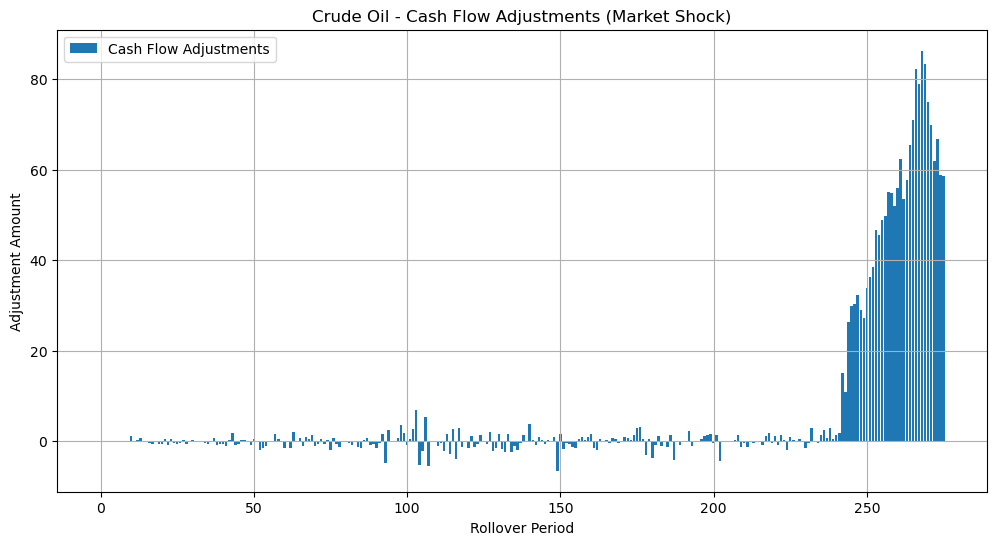

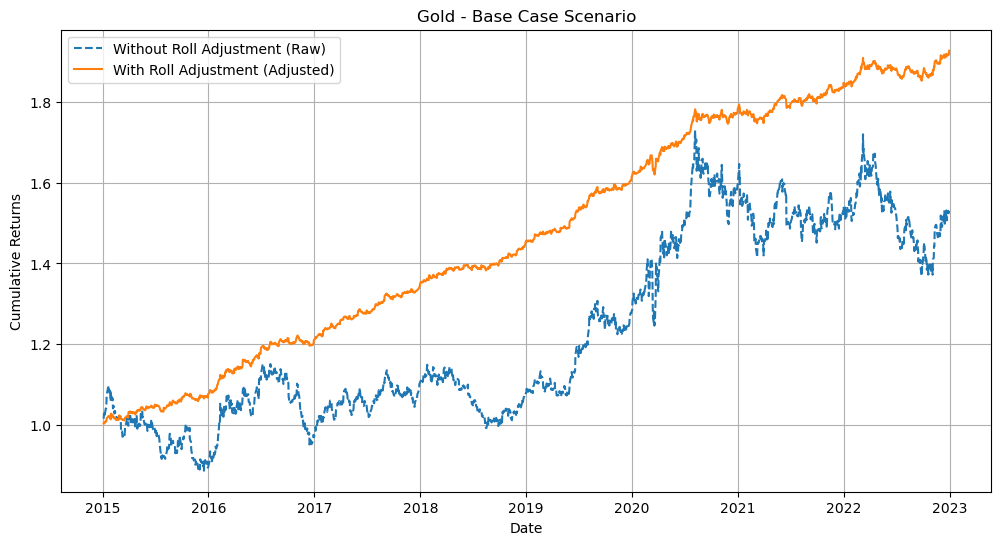

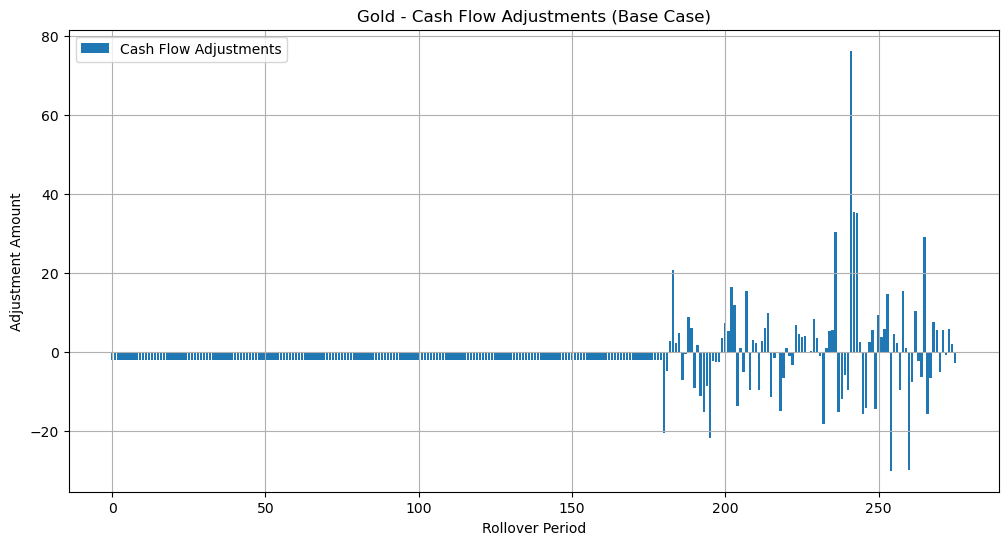

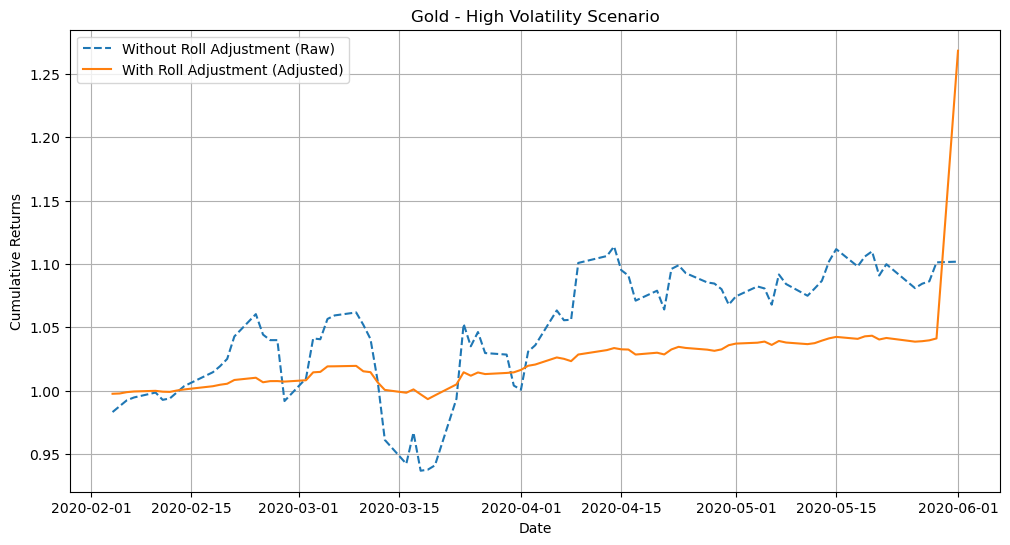

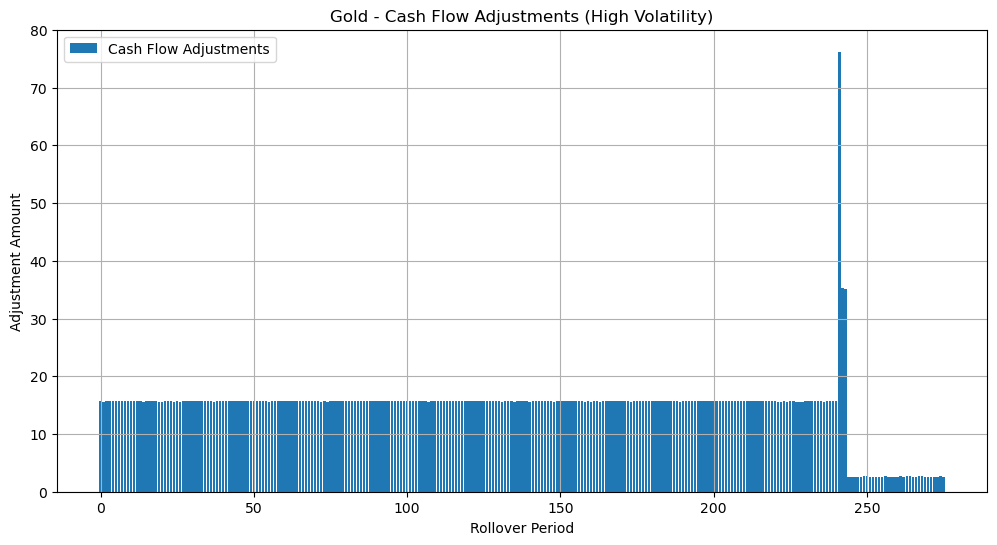

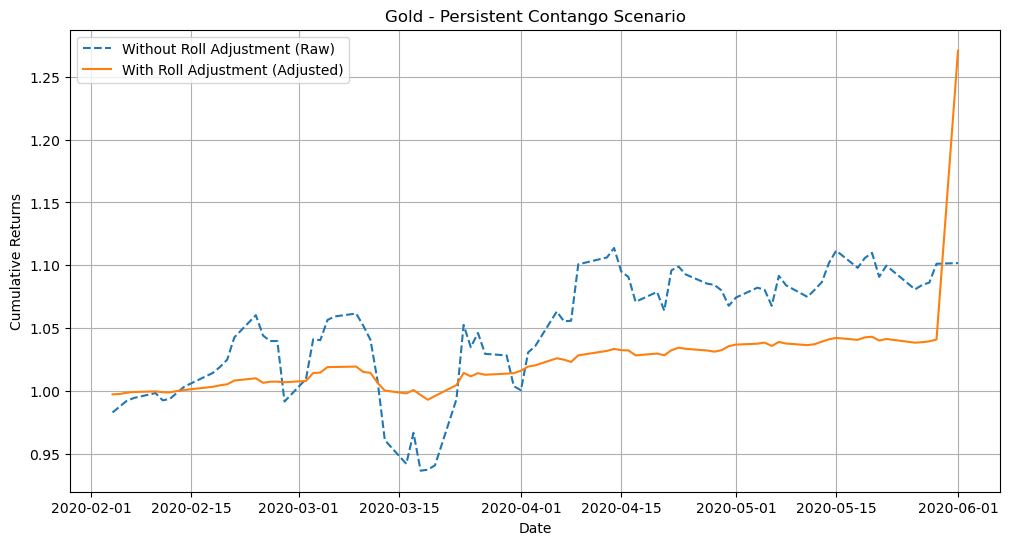

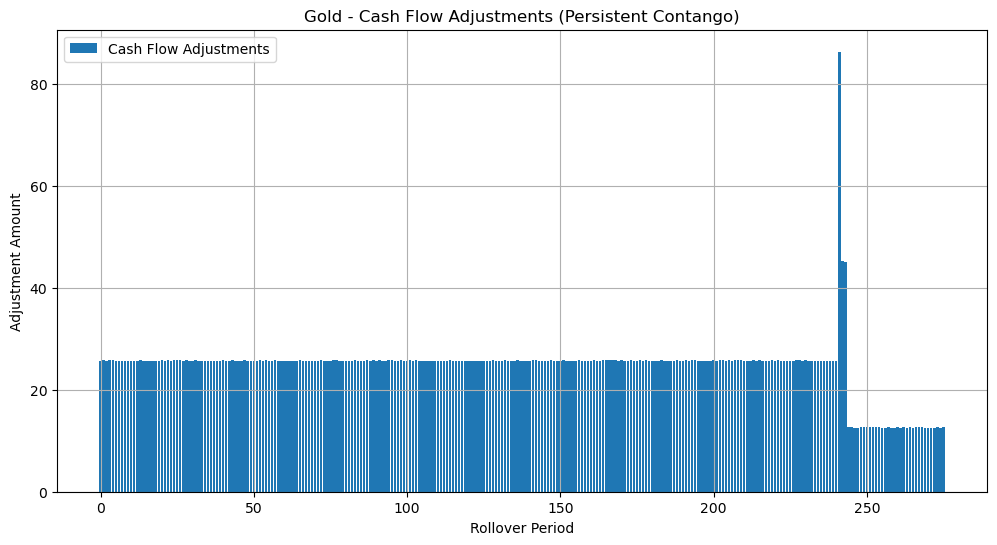

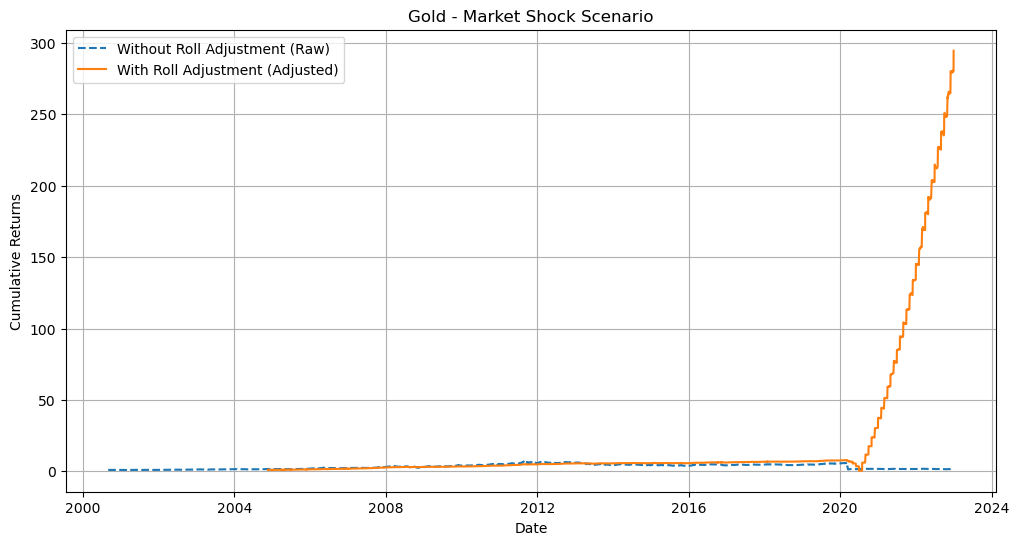

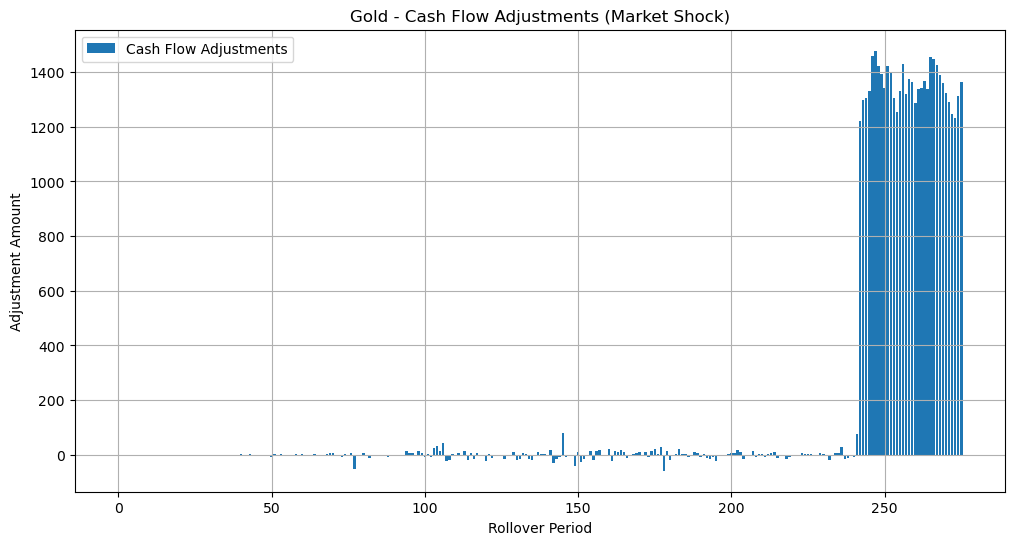

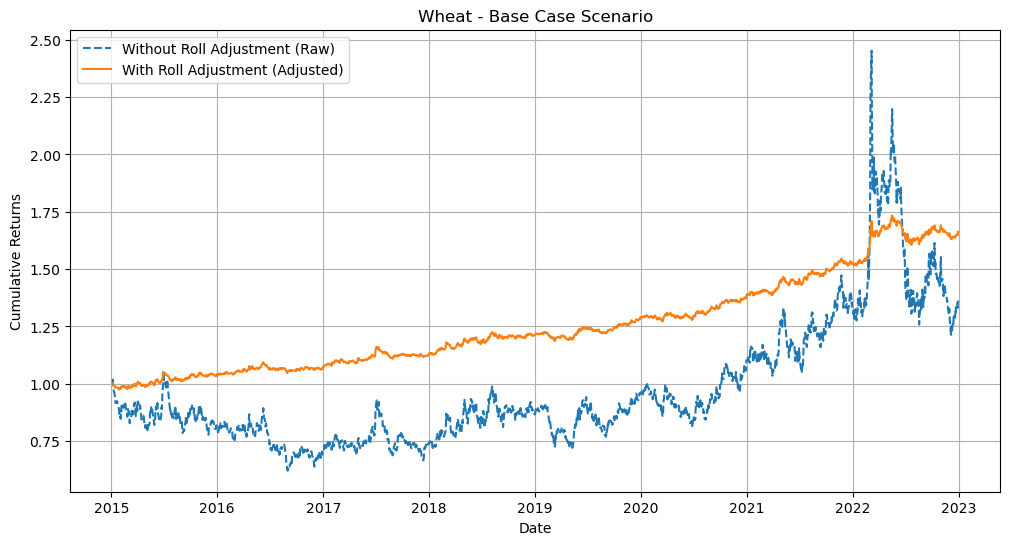

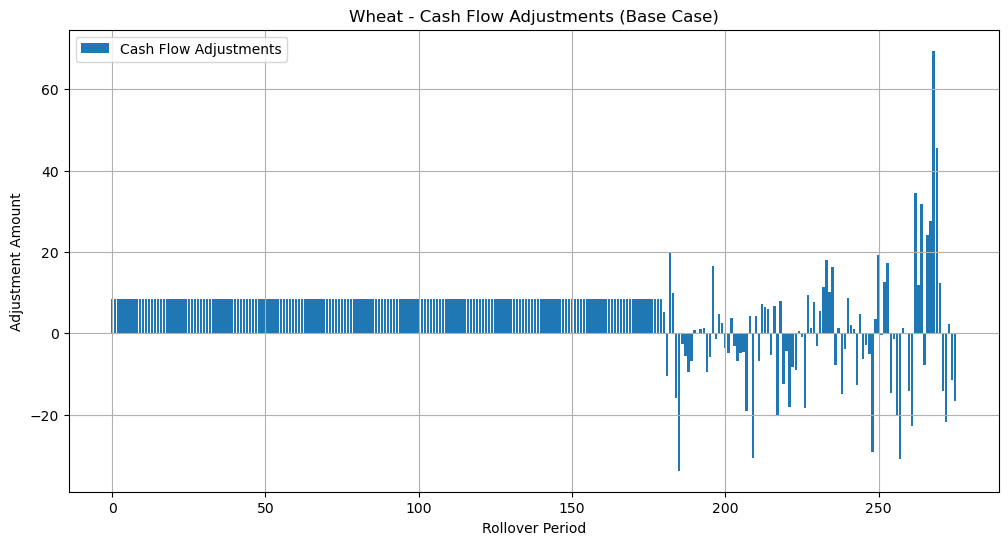

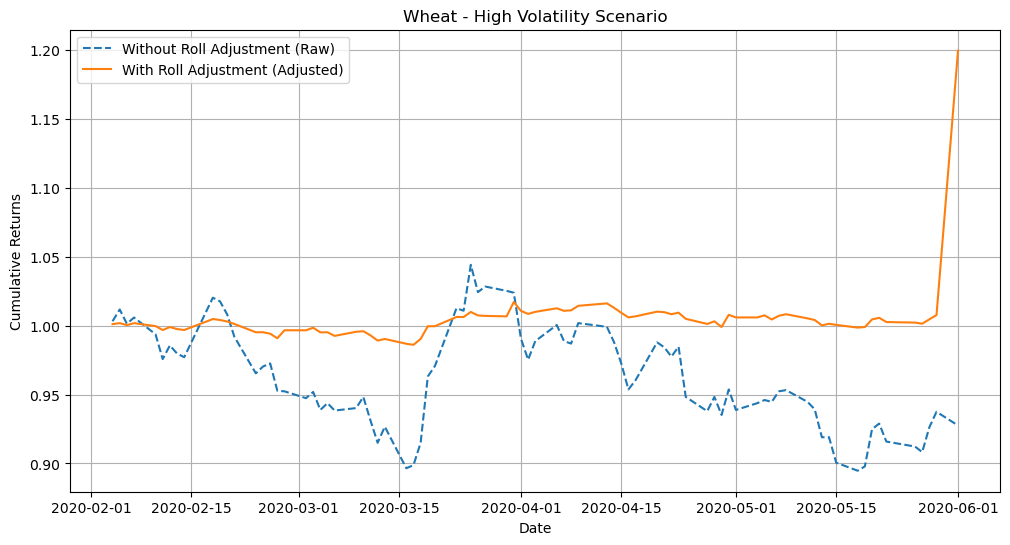

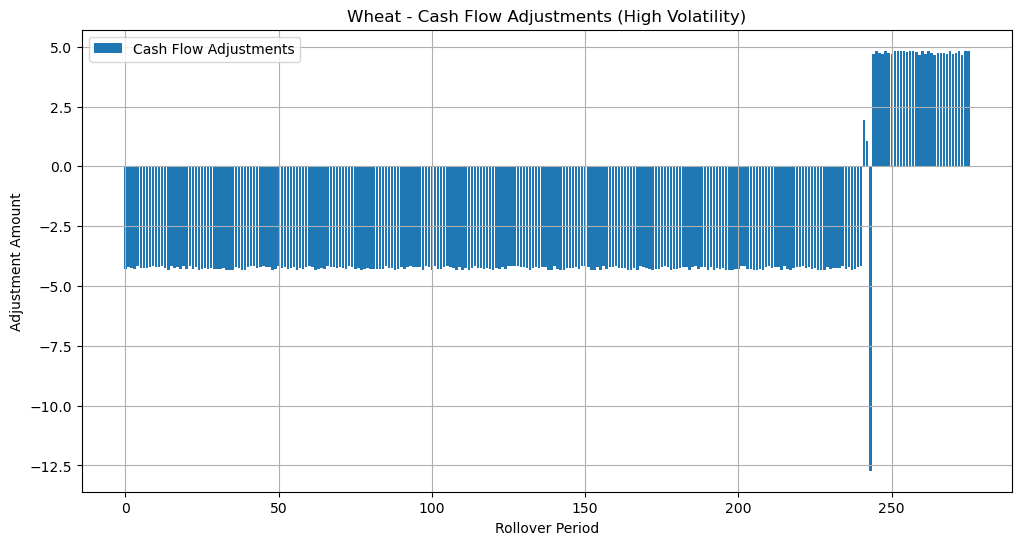

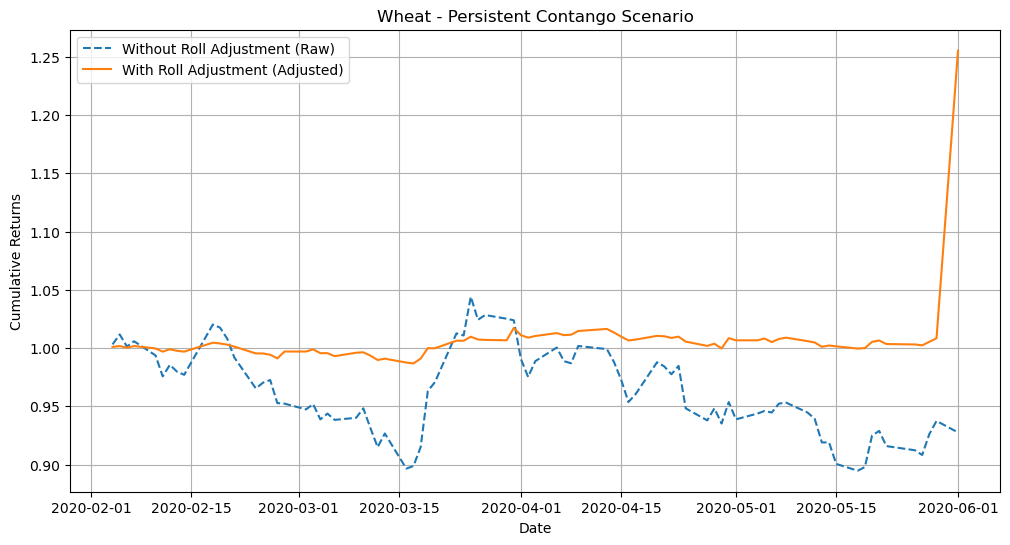

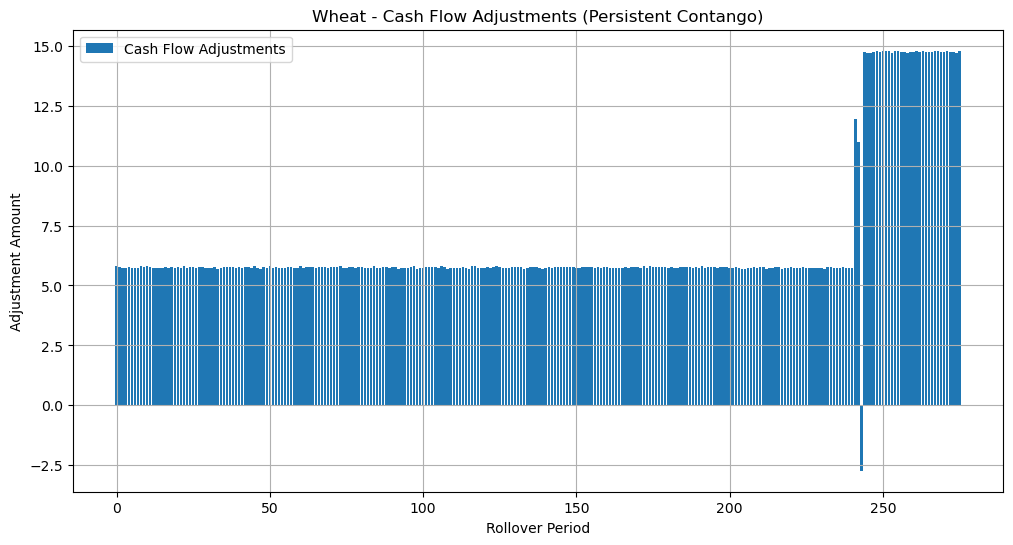

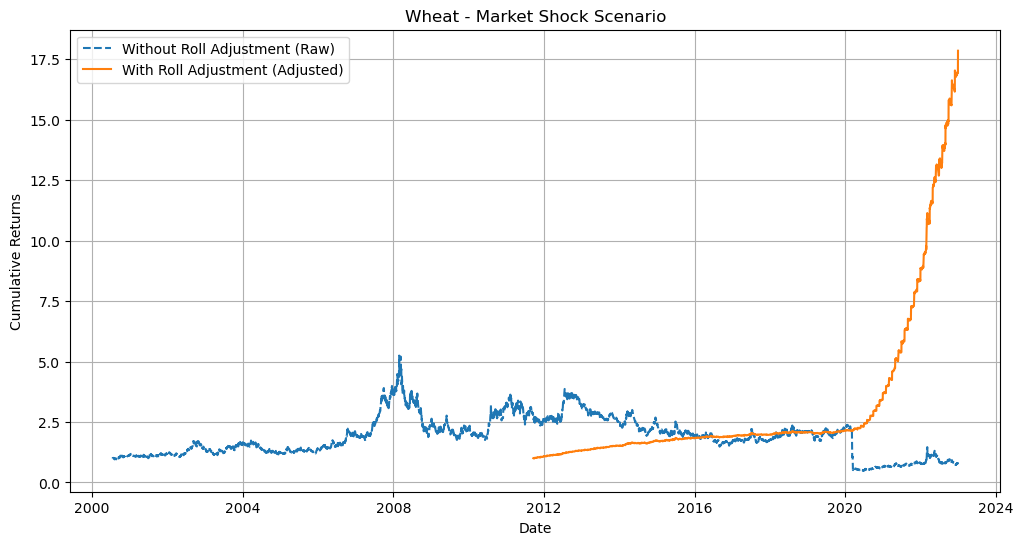

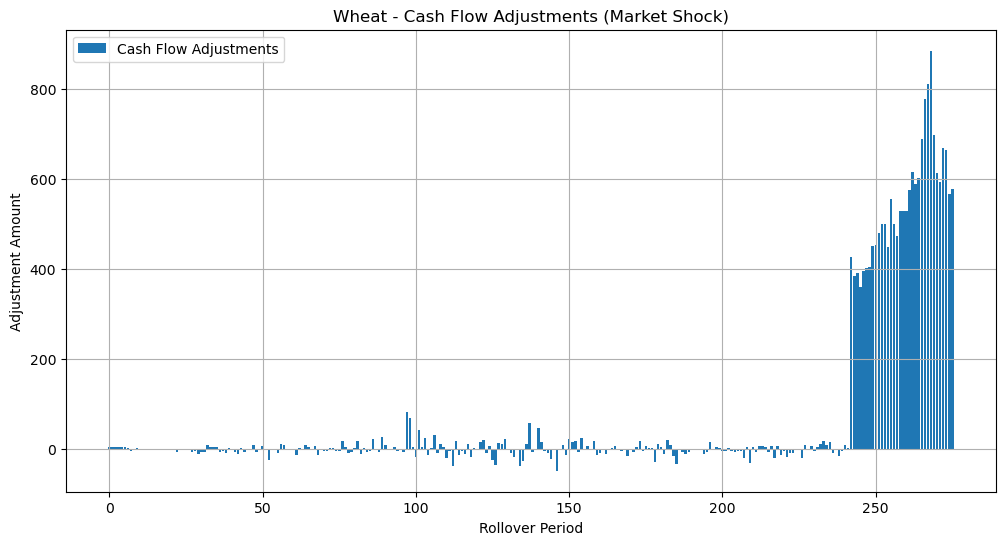

In [19]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate roll-adjusted price series
def roll_futures(data, roll_dates, basis_risk=0.0, contango_bias=0):
    """Adjust futures prices for roll gaps and simulate basis risk."""
    rolled_prices = data.copy()
    cumulative_gap = 0  # Start with zero cumulative roll gap
    cash_flow = []  # Track cash flow adjustments due to roll gaps

    for roll_date in roll_dates:
        if roll_date not in data.index:
            roll_date = data.index[data.index.get_indexer([roll_date], method="nearest")[0]]
        
        # Calculate roll gap and basis risk
        roll_gap = data.loc[roll_date, "Open"] - data.loc[roll_date, "Close"] + contango_bias
        basis_adjustment = basis_risk * np.random.uniform(-1, 1)
        cumulative_gap += roll_gap + basis_adjustment

        # Adjust future prices
        rolled_prices.loc[roll_date:, "Close"] -= cumulative_gap

        # Track cash flow impact
        cash_flow.append(roll_gap + basis_adjustment)

    return rolled_prices, cash_flow

# Simulate MGRM's hedging strategy
def mgrm_strategy(futures_data, spot_data, roll_dates, hedge_ratio=1.0, basis_risk=0.0, contango_bias=0):
    """Simulate MGRM's multi-legged hedging strategy."""
    rolled_prices, cash_flow = roll_futures(futures_data, roll_dates, basis_risk, contango_bias)
    spot_returns = spot_data['Close'].pct_change()
    futures_returns = rolled_prices['Close'].pct_change()
    hedged_returns = hedge_ratio * futures_returns + (1 - hedge_ratio) * spot_returns
    hedged_cum_returns = (1 + hedged_returns).cumprod()
    return hedged_cum_returns, cash_flow

# Compare strategies for multiple assets
def compare_assets(assets, global_start_date, global_end_date, roll_dates, hedge_ratio, scenarios):
    results = {}
    for asset in assets:
        futures_data = get_data(asset["futures"], global_start_date, global_end_date)
        spot_data = get_data(asset["spot"], global_start_date, global_end_date)

        results[asset["name"]] = {}
        for scenario_name, scenario_params in scenarios.items():
            print(f"\nTesting {scenario_name} for {asset['name']}...")
            basis_risk = scenario_params.get("basis_risk", 0.05)
            contango_bias = scenario_params.get("contango_bias", 0)
            shock_dates = scenario_params.get("shock_dates", [])
            scenario_start_date = scenario_params.get("start_date", global_start_date)
            scenario_end_date = scenario_params.get("end_date", global_end_date)

            # Filter data for scenario-specific period
            scenario_futures_data = futures_data.loc[scenario_start_date:scenario_end_date].copy()
            scenario_spot_data = spot_data.loc[scenario_start_date:scenario_end_date].copy()

            # Apply shocks
            for shock_date in shock_dates:
                if shock_date in scenario_futures_data.index:
                    scenario_futures_data.loc[shock_date:, "Close"] *= 0.5  # Simulate a price collapse

            raw_returns = scenario_futures_data['Close'].pct_change()
            raw_cum_returns = (1 + raw_returns).cumprod()
            rolled_cum_returns, cash_flow = mgrm_strategy(
                scenario_futures_data, scenario_spot_data, roll_dates, hedge_ratio, basis_risk, contango_bias
            )

            results[asset["name"]][scenario_name] = {
                "raw_cum_returns": raw_cum_returns,
                "rolled_cum_returns": rolled_cum_returns,
                "cash_flow": cash_flow
            }
    return results

# Fetch data from Yahoo Finance
def get_data(ticker, start, end):
    """Fetch historical futures or spot data from yfinance."""
    print(f"Fetching data for {ticker}...")
    return yf.download(ticker, start=start, end=end)

# Main simulation
if __name__ == "__main__":
    # Define assets
    assets = [
        {"futures": "CL=F", "spot": "USO", "name": "Crude Oil"},
        {"futures": "GC=F", "spot": "GLD", "name": "Gold"},
        {"futures": "ZW=F", "spot": "WEAT", "name": "Wheat"}
    ]

    # Global start and end dates
    global_start_date = "2000-01-01"
    global_end_date = "2023-01-01"
    roll_freq = "M"  # Monthly rollovers
    hedge_ratio = 0.8  # 80% hedging with futures

    # Define scenarios
    scenarios = {
        "Base Case": {"basis_risk": 0.05, "start_date": "2015-01-01", "end_date": "2023-01-01"},
        "High Volatility": {"basis_risk": 0.1, "start_date": "2020-02-01", "end_date": "2020-06-01"},
        "Persistent Contango": {"contango_bias": 10, "start_date": "2020-02-01", "end_date": "2020-06-01"},
        "Market Shock": {"shock_dates": ["2020-03-09", "2020-03-16"]}
    }

    # Generate roll dates
    roll_dates = pd.date_range(start=global_start_date, end=global_end_date, freq=roll_freq)

    # Run simulations
    results = compare_assets(assets, global_start_date, global_end_date, roll_dates, hedge_ratio, scenarios)

    # Plot results for each asset and scenario
    for asset_name, asset_results in results.items():
        for scenario_name, scenario_results in asset_results.items():
            plt.figure(figsize=(12, 6))
            plt.plot(scenario_results["raw_cum_returns"], label="Without Roll Adjustment (Raw)", linestyle="--")
            plt.plot(scenario_results["rolled_cum_returns"], label="With Roll Adjustment (Adjusted)", linestyle="-")
            plt.title(f"{asset_name} - {scenario_name} Scenario")
            plt.xlabel("Date")
            plt.ylabel("Cumulative Returns")
            plt.legend()
            plt.grid()
            plt.show()

            # Plot cash flow adjustments
            plt.figure(figsize=(12, 6))
            plt.bar(range(len(scenario_results["cash_flow"])), scenario_results["cash_flow"], label="Cash Flow Adjustments")
            plt.title(f"{asset_name} - Cash Flow Adjustments ({scenario_name})")
            plt.xlabel("Rollover Period")
            plt.ylabel("Adjustment Amount")
            plt.legend()
            plt.grid()
            plt.show()
